**I built this project as part of my hands-on practice using a YouTube tutorial as guidance.**

**Dataset:** California Housing Prices - `housing.csv`

**Kaggle link:** https://www.kaggle.com/datasets/camnugent/california-housing-prices

> Process: EDA → preprocessing → baseline model → model selection (CV) → tuning (GridSearchCV) → final evaluation → inference.


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection  import train_test_split ,KFold ,cross_validate , GridSearchCV
from sklearn.pipeline import Pipeline 
from sklearn.compose  import ColumnTransformer 
from sklearn.preprocessing  import StandardScaler , OneHotEncoder 
from sklearn.impute  import SimpleImputer
from sklearn.linear_model import LinearRegression ,Ridge , Lasso 
from sklearn.ensemble import RandomForestRegressor ,HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error ,root_mean_squared_error ,r2_score


**Configurations**

In [3]:
pd.set_option("display.max_columns",None)
pd.set_option("display.float_format",lambda x : f"{x:.3f}")
sns.set_theme(style="darkgrid")

plt.rcParams.update({
    "axes.titlesize":10,
    "axes.labelsize":9,
    "xtick.labelsize":8,
    "ytick.labelsize":8
})
RandomState = 42
FilePath = r"C:\mahmouD\Projects\house predection Siddhardhan\my code\housing.csv"
TargetCol = "median_house_value"

**Load Data**

In [4]:
df = pd.read_csv(FilePath)
df.shape 

(20640, 10)

In [5]:
df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.230,37.880,41.000,880.000,129.000,322.000,126.000,8.325,452600.000,NEAR BAY
1,-122.220,37.860,21.000,7099.000,1106.000,2401.000,1138.000,8.301,358500.000,NEAR BAY
2,-122.240,37.850,52.000,1467.000,190.000,496.000,177.000,7.257,352100.000,NEAR BAY
3,-122.250,37.850,52.000,1274.000,235.000,558.000,219.000,5.643,341300.000,NEAR BAY
4,-122.250,37.850,52.000,1627.000,280.000,565.000,259.000,3.846,342200.000,NEAR BAY


**Explorty Data Analyis(EDA)**

In [6]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

**Columns Details From Kaggle**

1. longitude: A measure of how far west a house is; a higher value is farther west

2. latitude: A measure of how far north a house is; a higher value is farther north

3. housingMedianAge: Median age of a house within a block; a lower number is a newer building

4. totalRooms: Total number of rooms within a block

5. totalBedrooms: Total number of bedrooms within a block

6. population: Total number of people residing within a block

7. households: Total number of households, a group of people residing within a home unit, for a block

8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. medianHouseValue: Median house value for households within a block (measured in US Dollars)

10. oceanProximity: Location of the house w.r.t ocean/sea

**Basic Dataset Overview**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
NCol = df.select_dtypes(include=[np.number]).columns.tolist()
CCol = df.select_dtypes(include=["object"]).columns.tolist()

print("Target column is =>",TargetCol)
print("Numirical columns =>",NCol)
print("Categorical colums =>",CCol)

Target column is => median_house_value
Numirical columns => ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Categorical colums => ['ocean_proximity']


**Missing Values Analysis**

In [9]:
print("Missing values is:")
print(df.isna().sum())

Missing values is:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


**Check Presence of Encoded Missing Values**

In [10]:
for col in df.columns:
    print(df[col].value_counts().head())

longitude
-118.310    162
-118.300    160
-118.290    148
-118.270    144
-118.320    142
Name: count, dtype: int64
latitude
34.060    244
34.050    236
34.080    234
34.070    231
34.040    221
Name: count, dtype: int64
housing_median_age
52.000    1273
36.000     862
35.000     824
16.000     771
17.000     698
Name: count, dtype: int64
total_rooms
1527.000    18
1613.000    17
1582.000    17
2127.000    16
2053.000    15
Name: count, dtype: int64
total_bedrooms
280.000    55
331.000    51
345.000    50
343.000    49
393.000    49
Name: count, dtype: int64
population
891.000     25
1052.000    24
761.000     24
850.000     24
1227.000    24
Name: count, dtype: int64
households
306.000    57
335.000    56
386.000    56
282.000    55
429.000    54
Name: count, dtype: int64
median_income
3.125     49
15.000    49
2.875     46
4.125     44
2.625     44
Name: count, dtype: int64
median_house_value
500001.000    965
137500.000    122
162500.000    117
112500.000    103
187500.000     93
Na

**Duplicated Values**

In [11]:
duplcateMask = df.duplicated()
numofDuplicated = duplcateMask.sum()
print(f"num of duplicated values =>{numofDuplicated}")


num of duplicated values =>0


In [12]:
df[NCol].describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000,20640.000,20640.000,20640.000,20433.000,20640.000,20640.000,20640.000,20640.000
mean,-119.570,35.632,28.639,2635.763,537.871,1425.477,499.540,3.871,206855.817
std,2.004,2.136,12.586,2181.615,421.385,1132.462,382.330,1.900,115395.616
min,-124.350,32.540,1.000,2.000,1.000,3.000,1.000,0.500,14999.000
25%,-121.800,33.930,18.000,1447.750,296.000,787.000,280.000,2.563,119600.000
50%,-118.490,34.260,29.000,2127.000,435.000,1166.000,409.000,3.535,179700.000
75%,-118.010,37.710,37.000,3148.000,647.000,1725.000,605.000,4.743,264725.000
max,-114.310,41.950,52.000,39320.000,6445.000,35682.000,6082.000,15.000,500001.000


**Countplot for Categorical Columns**

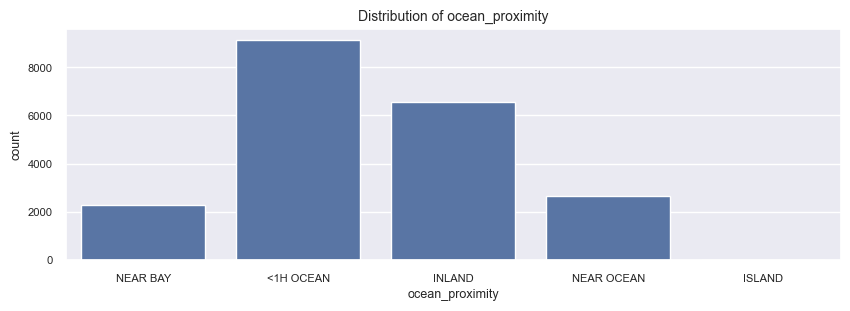

In [13]:
for col in CCol:
    plt.figure(figsize=(10,3))
    sns.countplot(x=col ,data=df)
    plt.title(f"Distribution of {col}")
    plt.show()

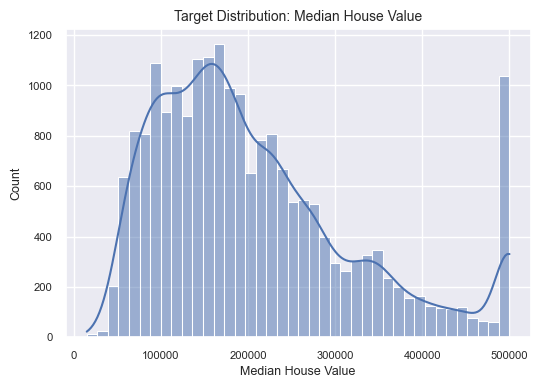

In [14]:
plt.figure(figsize=(6,4))
sns.histplot(df[TargetCol],bins=40,kde=True)
plt.title("Target Distribution: Median House Value")
plt.xlabel("Median House Value")
plt.show() 

**Histogram Plot - Distribution**

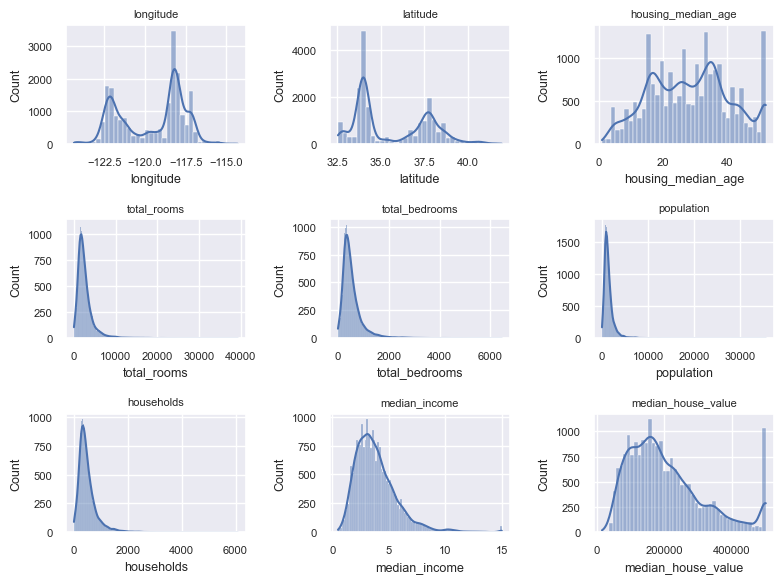

In [15]:
fig,axes = plt.subplots(3,3 ,figsize= (8,6))
axes = axes.flatten()
for i , col  in enumerate(NCol):
    sns.histplot(df[col] ,kde = True ,ax = axes[i])
    axes[i].set_title(col , fontsize = 8)

plt.tight_layout()
plt.show()


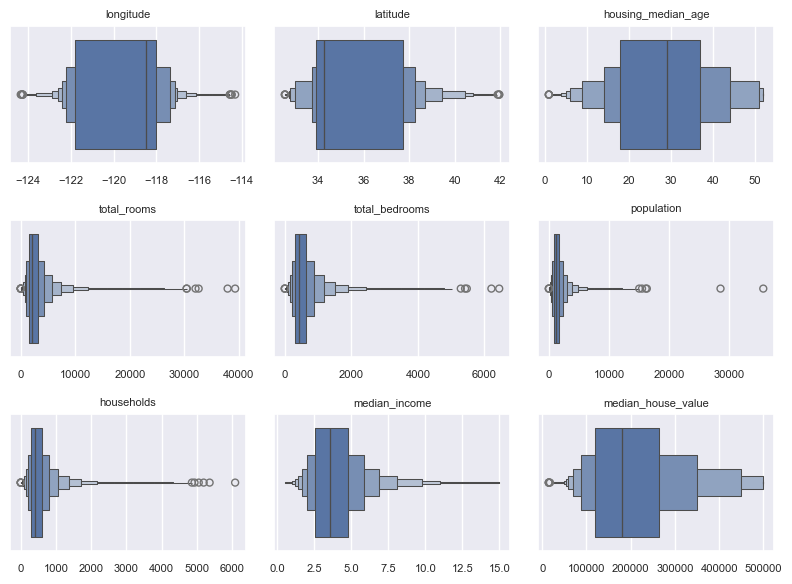

In [16]:
fig , axes = plt.subplots(3,3,figsize = (8,6))
axes = axes.flatten()
for i , col in enumerate(NCol):
    sns.boxenplot(x=df[col],ax=axes[i])
    axes[i].set_title(col,fontsize = 8)
    axes[i].set_xlabel("")


plt.tight_layout()
plt.show()

**Correlation**

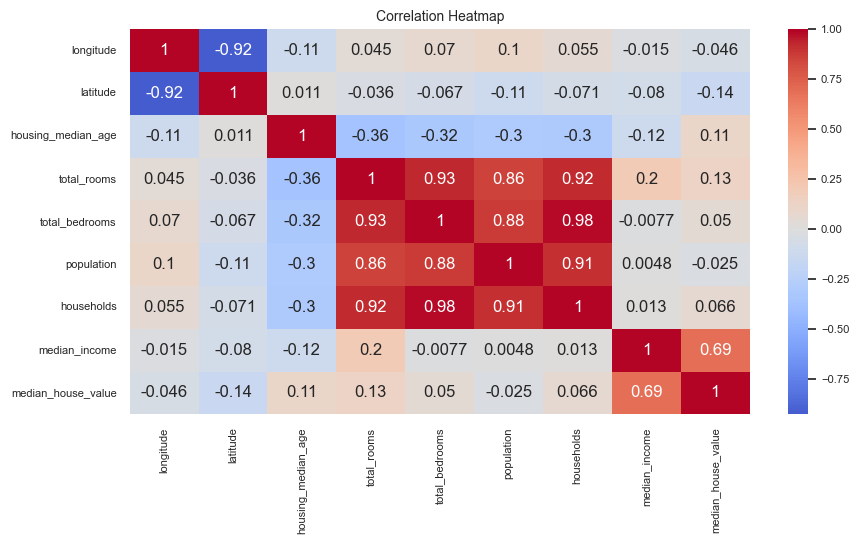

In [17]:
plt.figure(figsize=(10,5))
sns.heatmap( df[NCol].corr(),annot=True,cmap="coolwarm",center=0)
plt.title("Correlation Heatmap")
plt.show()

In [18]:
#correlation wit target 
coor_with_tar = df[NCol].corr()[TargetCol].sort_values(ascending=False)
print("Correlation with target:")
print(coor_with_tar)

Correlation with target:
median_house_value    1.000
median_income         0.688
total_rooms           0.134
housing_median_age    0.106
households            0.066
total_bedrooms        0.050
population           -0.025
longitude            -0.046
latitude             -0.144
Name: median_house_value, dtype: float64


**Data Preprocesing**

In [19]:
x = df.drop(columns=[TargetCol])
y = df[TargetCol]

In [20]:
x.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.230,37.880,41.000,880.000,129.000,322.000,126.000,8.325,NEAR BAY
1,-122.220,37.860,21.000,7099.000,1106.000,2401.000,1138.000,8.301,NEAR BAY
2,-122.240,37.850,52.000,1467.000,190.000,496.000,177.000,7.257,NEAR BAY
3,-122.250,37.850,52.000,1274.000,235.000,558.000,219.000,5.643,NEAR BAY
4,-122.250,37.850,52.000,1627.000,280.000,565.000,259.000,3.846,NEAR BAY


In [21]:
y.head()

0   452600.000
1   358500.000
2   352100.000
3   341300.000
4   342200.000
Name: median_house_value, dtype: float64

In [22]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=RandomState , test_size=.2)
    

In [23]:
numFeat = X_train.select_dtypes(include=[np.number]).columns.tolist()
numFeat

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [24]:
catFeat = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
catFeat

['ocean_proximity']

In [25]:
numeric_trans = Pipeline(
    steps=[
        ("imputer" , SimpleImputer(strategy="median")),
        ("scaler" , StandardScaler())   
    ]
)

catig_trans = Pipeline(
    steps=[
        ("imputer" , SimpleImputer(strategy="most_frequent")),
        ("1🔥en" , OneHotEncoder(handle_unknown="ignore"))   
    ]
)


preprocess = ColumnTransformer(
    transformers=[ ("numiric",numeric_trans ,numFeat),("categorical",catig_trans,catFeat)]
)

**Baseline Model (No CV , No Tuning)**

In [26]:
baseline_pipe = Pipeline(
    steps=[
        ("preprocessing",preprocess),("model",LinearRegression())

    ])

In [27]:
baseline_pipe.fit(X_train,y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numiric', ...), ('categorical', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different tr

In [28]:
train_baseline_predection = baseline_pipe.predict(X_train)
test_baseline_predection = baseline_pipe.predict(X_test)

In [29]:
test_baseline_predection[:5]

array([ 54261.02768976, 124430.91772796, 255694.95828244, 268208.01035997,
       262975.01360647])

In [30]:
y_train[:5]

14196   103000.000
8267    382100.000
17445   172600.000
14265    93400.000
2271     96500.000
Name: median_house_value, dtype: float64

In [31]:
train_baseline_rmse = root_mean_squared_error(y_train,train_baseline_predection)
train_baseline_mae = mean_absolute_error(y_train,train_baseline_predection)
train_baseline_r2 = r2_score(y_train,train_baseline_predection)

print("train base line matrics:")
print(f"rmse=>{train_baseline_rmse}")
print(f"mae=>{train_baseline_mae}")
print(f"r2=>{train_baseline_r2}")   

train base line matrics:
rmse=>68433.93736666226
mae=>49594.842094724365
r2=>0.6496648627123224


In [32]:
test_baseline_rmse = root_mean_squared_error(y_test,test_baseline_predection)
test_baseline_mae = mean_absolute_error(y_test,test_baseline_predection)
test_baseline_r2 = r2_score(y_test,test_baseline_predection)

print("train base line matrics:")
print(f"rmse=>{test_baseline_rmse}")
print(f"mae=>{test_baseline_mae}")
print(f"r2=>{test_baseline_r2}")  

train base line matrics:
rmse=>70059.19333925014
mae=>50670.48923565362
r2=>0.6254382675296266


**Model Selection and Optimazation**

In [33]:
#models to try
models ={
    "LinearRegression":LinearRegression(),
    "Ridge" : Ridge(random_state=RandomState),
    "Lasso":Lasso(random_state=RandomState , max_iter=10000),
    "RandomForestRegressor":RandomForestRegressor(),
    "HistGB" : HistGradientBoostingRegressor()
}

In [34]:
k = 5
cv = KFold(n_splits=k,shuffle=True, random_state=RandomState)

In [35]:
scoring ={
    "rmse":"neg_root_mean_squared_error",
    "mae":"neg_mean_absolute_error",
    "r2":"r2"
}

In [36]:
rows = []

for name , model in models.items():
    lo_pipe = Pipeline(
        steps=[
            ("preprocessing" , preprocess),
            ("model",model)
        ]
    )

    scores = cross_validate(lo_pipe , X_train , y_train , cv= cv, scoring=scoring,n_jobs=1)

    rows.append({
        "model" : name ,
        "cv_rmse":-scores["test_rmse"].mean(),
        "cv_mae":-scores["test_mae"].mean(),
        "cv_r2":scores["test_r2"].mean()
    })

#sort based on lowest rmse 
cv_results = pd.DataFrame(rows).sort_values("cv_rmse")
print("============ CV Model Comparision ===========")
print(cv_results)

============ CV Model Comparision ===========
                   model   cv_rmse    cv_mae  cv_r2
4                 HistGB 47976.095 32139.666  0.828
3  RandomForestRegressor 49461.784 32314.862  0.817
1                  Ridge 68595.617 49664.331  0.648
2                  Lasso 68603.233 49667.263  0.648
0       LinearRegression 68604.163 49667.159  0.648


In [37]:
cv_results

,model,cv_rmse,cv_mae,cv_r2
4,HistGB,47976.095,32139.666,0.828
3,RandomForestRegressor,49461.784,32314.862,0.817
1,Ridge,68595.617,49664.331,0.648
2,Lasso,68603.233,49667.263,0.648
0,LinearRegression,68604.163,49667.159,0.648


In [38]:
scores

{'fit_time': array([2.35838461, 0.64767432, 0.57574797, 0.65088797, 0.58422279]),
 'score_time': array([0.05297589, 0.04059362, 0.05660963, 0.04718852, 0.04416704]),
 'test_rmse': array([-49448.61263885, -47211.71456731, -47095.21861137, -49397.95896867,
        -46726.97202258]),
 'test_mae': array([-33170.43608734, -31957.05893721, -31561.91236831, -32344.53911205,
        -31664.38258095]),
 'test_r2': array([0.82281255, 0.83219912, 0.83368478, 0.81886517, 0.83125245])}

In [39]:
best_row = cv_results.iloc[0]
best_row

model        HistGB
cv_rmse   47976.095
cv_mae    32139.666
cv_r2         0.828
Name: 4, dtype: object

**Best Model => HistGradientBoostingRegressor**

In [40]:
hgb_pipe = Pipeline(
    steps=[
        ("preprocessing" , preprocess),
        ("model",HistGradientBoostingRegressor(random_state=RandomState))
    ]
)

In [41]:
#hyperparameter combiniation
param_grid = {
    "model__learning_rate":[0.03,0.05,0.1],
    "model__max_depth":[None,3,6],
    "model__max_leaf_nodes":[15,31,63],
    "model__min_samples_leaf":[20,50,100],
    "model__l2_regularization":[0,0.1,1]
}

In [42]:
grid = GridSearchCV(
    estimator=hgb_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

In [43]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__l2_regularization': [0, 0.1, ...], 'model__learning_rate': [0.03, 0.05, ...], 'model__max_depth': [None, 3, ...], 'model__max_leaf_nodes': [15, 31, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n_split... shuffle=True)
,"verbose verbose: intControls th

In [44]:
print("===== Tuned HistGB (CV) parameters =====")
print("Best CV rmse => ", -grid.best_score_)
print("Best Params =>" , grid.best_params_)

===== Tuned HistGB (CV) parameters =====
Best CV rmse =>  47408.35933729127
Best Params => {'model__l2_regularization': 0.1, 'model__learning_rate': 0.1, 'model__max_depth': None, 'model__max_leaf_nodes': 63, 'model__min_samples_leaf': 20}


**Retrain with Best Parameters**

In [45]:
best_hgb = Pipeline(
    steps=[
        ("preprocessing" , preprocess),
        ("model",HistGradientBoostingRegressor(
           l2_regularization= 0.1,
           learning_rate= 0.1,
           max_depth= None, 
           max_leaf_nodes= 63,
            min_samples_leaf= 20

        ))
    ]
)

In [46]:
best_hgb.fit(X_train,y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numiric', ...), ('categorical', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different tr

**Final Evaluation**

In [47]:
train_final_pred = best_hgb.predict(X_train)

train_final_rmse = root_mean_squared_error(y_train,train_final_pred)
train_final_mae = mean_absolute_error(y_train,train_final_pred)
train_final_r2 = r2_score(y_train,train_final_pred)

print("========== Final Model (Tuned HGB) Test Performance ==========")
print(f"rmse => {train_final_rmse}")
print(f"mae => {train_final_mae}")
print(f"r2 => {train_final_r2}")

========== Final Model (Tuned HGB) Test Performance ==========
rmse => 35975.271518424
mae => 24485.984749121097
r2 => 0.9031836284126841


In [48]:
test_final_pred = best_hgb.predict(X_test)

test_final_rmse = root_mean_squared_error(y_test,test_final_pred)
test_final_rme = mean_absolute_error(y_test,test_final_pred)
test_final_r2 = r2_score(y_test,test_final_pred)

print("========== Final Model (Tuned HGB) Test Performance ==========")
print(f"rmse => {test_final_rmse}")
print(f"mae => {test_final_rme}")
print(f"r2 => {test_final_r2}")

========== Final Model (Tuned HGB) Test Performance ==========
rmse => 46760.73572358787
mae => 30902.015688105188
r2 => 0.8331386275797281


**Final Model Plot**

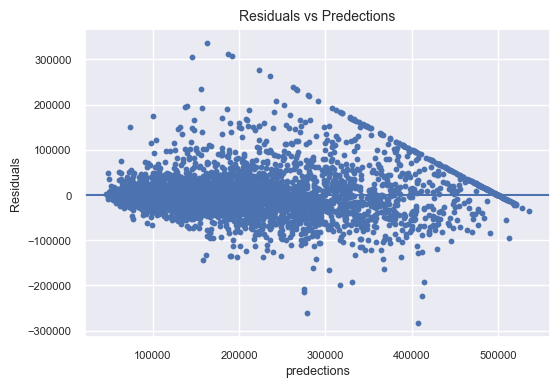

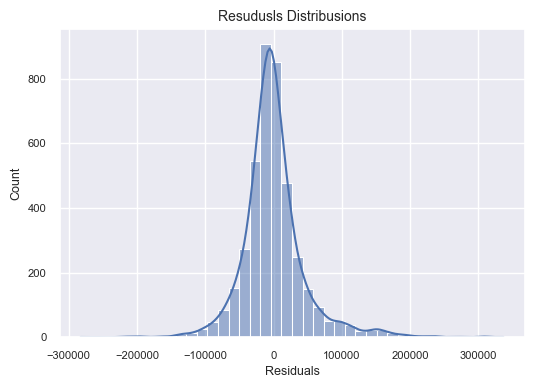

In [49]:
residuals = y_test - test_final_pred

plt.figure(figsize=(6,4))
plt.scatter(test_final_pred,residuals,s=10)
plt.axhline(0)
plt.title("Residuals vs Predections")
plt.xlabel("predections")
plt.ylabel("Residuals")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(residuals , bins = 40,kde=True)
plt.title("Resudusls Distribusions")
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.show()

**Build a Predective Function**

In [50]:
def predect_realestaite_price(
        model,
        longitude:float,
        latitude:float,
        housing_median_age:float,
        total_rooms:float,
        total_bedrooms:float,
        population:float,
        households:float,
        median_income:float,
        ocean_proximity:str
        
):
    new_row_in_df = pd.DataFrame([{
        'longitude':longitude,
        'latitude':latitude,
        'housing_median_age':housing_median_age,
        'total_rooms':total_rooms,
        'total_bedrooms':total_bedrooms,
        'population':population,
        'households':households,
        'median_income':median_income,
        'ocean_proximity':ocean_proximity
    }])

    return float(model.predict(new_row_in_df)[0])

In [51]:
predction_state = predect_realestaite_price(
          model = best_hgb,
        longitude=-122.23,
        latitude=37.880,
        housing_median_age=41,
        total_rooms=880,
        total_bedrooms=129,
        population=322,
        households=126,
        median_income=8.3252,
        ocean_proximity="NEAR BAY"  
)
print(f"Price will be : {predction_state}")

Price will be : 446663.24831709743
